In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import normaltest
from scipy.stats import shapiro
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import os

# CMA aging Atlas: Heart
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Heart data, Smart-seq2 assay in .h5ad format was used for further analysis.

In [2]:
# Creating folder for outputs
os.makedirs('../Khwaja_et_al_outputs/Heart')

## Importing and preprocessing data

In [2]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Exp. 2_Tabula muris/Files/TM_heart.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [3]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1777.91it/s]
9669it [00:35, 274.93it/s]


In [4]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,organism_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,NCBITaxon:10090,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,0.025783
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219727,10,...,NCBITaxon:10090,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,0.191401
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,NCBITaxon:10090,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,0.093941
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.130371,3,...,NCBITaxon:10090,fibroblast of cardiac tissue,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,-0.107985
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,NCBITaxon:10090,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,-0.015457


## CMA net score/cell type (fold over whole tissue)

In [6]:
# Checking n of mice 
print(list(barcode['mouse.id'].unique()))

['18_46_F', '18_53_M', '18_47_F', '24_60_M', '24_61_M', '24_59_M', '24_58_M', '3_56_F', '3_39_F', '3_38_F', '3_9_M', '3_8_M', '3_11_M', '3_10_M', '3_10_M/3_11_M', '3_38_F/3_39_F']


**Mice n for Liver**
    - Young females: 4
    - Young males: 4
    - Old females: 2
    - Old males: 5

In [5]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,0.025783,18-24m
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219727,10,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,0.191401,18-24m
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,0.093941,18-24m
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.130371,3,...,fibroblast of cardiac tissue,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,-0.107985,18-24m
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,-0.015457,18-24m


In [6]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,0.025783,18-24m,-0.001115
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219727,10,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,0.191401,18-24m,0.164504
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,0.093941,18-24m,0.067043
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.130371,3,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,-0.107985,18-24m,-0.134883
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,-0.015457,18-24m,-0.042355


In [9]:
print(list(barcode.cell_type.unique()))

['B cell', 'fibroblast of cardiac tissue', 'endothelial cell of coronary artery', 'monocyte', 'macrophage', 'endocardial cell', 'valve cell', 'regular atrial cardiac myocyte', 'T cell', 'smooth muscle cell', 'regular ventricular cardiac myocyte']


In [7]:
# Generating new cell types combining some of them
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'cell_type'] == 'fibroblast of cardiac tissue':        
        barcode.loc[j, 'new_cell'] = 'fibroblast'

    elif barcode.loc[j, 'cell_type'] == 'endothelial cell of coronary artery':                
        barcode.loc[j, 'new_cell'] = 'endothelial cell'
    
    elif barcode.loc[j, 'cell_type'] == 'regular atrial cardiac myocyte':                
        barcode.loc[j, 'new_cell'] = 'myocyte'
    
    elif barcode.loc[j, 'cell_type'] == 'regular ventricular cardiac myocyte':                
        barcode.loc[j, 'new_cell'] = 'myocyte'
        
    else:
        barcode.loc[j, 'new_cell'] = barcode.loc[j, 'cell_type']
        
barcode.head()

100%|████████████████████████████████████████████████████████████████████████████| 9669/9669 [00:01<00:00, 5256.76it/s]


,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score,new_cell
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,normal,Mus musculus,female,heart,na,18 month-old stage,0.025783,18-24m,-0.001115,B cell
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219727,10,...,normal,Mus musculus,female,heart,na,18 month-old stage,0.191401,18-24m,0.164504,B cell
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,normal,Mus musculus,female,heart,na,18 month-old stage,0.093941,18-24m,0.067043,B cell
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.130371,3,...,normal,Mus musculus,female,heart,na,18 month-old stage,-0.107985,18-24m,-0.134883,fibroblast
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,normal,Mus musculus,female,heart,na,18 month-old stage,-0.015457,18-24m,-0.042355,B cell


In [8]:
cells = ['myocyte', 'smooth muscle cell', 'fibroblast', 'endothelial cell']

### Cell types stats

In [12]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tipo, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    
    for x in tipo:
        for y in años:
            mydata = df[(df['new_cell']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.net_score)            
            stat, p = normaltest(data)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")    
    df_norm = pd.DataFrame({"Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, "Result":result})
    return(df_norm)

In [13]:
normalidad(barcode, tipo=cells, años=['3m', '18-24m'])

,Cell,Age,n,Stat,p value,Result
0,myocyte,3m,205,6.372974,4.131677e-02,Not normal
1,myocyte,18-24m,345,0.634663,7.280892e-01,Normal
2,smooth muscle cell,3m,65,0.440679,8.022465e-01,Normal
3,smooth muscle cell,18-24m,38,0.934408,6.267524e-01,Normal
4,fibroblast,3m,2118,9.371960,9.223691e-03,Not normal
5,fibroblast,18-24m,1593,51.616557,6.188810e-12,Not normal
6,endothelial cell,3m,1179,2.405239,3.004063e-01,Normal
7,endothelial cell,18-24m,1515,4.640904,9.822918e-02,Normal


In [14]:
# T test for normal populations
for i in ['myocyte', 'endothelial cell']:
    # Levene
    group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    print('{} stats'.format(i.title()))
    print("Length 3m: " + str(len(group3)))
    print("Length 18-24m: " + str(len(group18_24)))
    stat, p = stats.levene(group3, group18_24)
    print("Levene's test pval = " + str(p))

    #t test
    if i == 'pneumocyte':
        stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=False)
        print("T test pval = " + str(p2))
        print('\n')
    
    else:
        stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=True)
        print("T test pval = " + str(p2))
        print('\n')

Myocyte stats
Length 3m: 205
Length 18-24m: 345
Levene's test pval = 0.870295373122985
T test pval = 0.0010844528016754668


Endothelial Cell stats
Length 3m: 1179
Length 18-24m: 1515
Levene's test pval = 0.5188128967164036
T test pval = 8.730287633906181e-07




C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\1610607619.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\1610607619.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])


In [15]:
# Calculating MWU test (for not normal distributions) for the cells of interest
for i in ['smooth muscle cell', 'fibroblast']:
    group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    print('{} statistics'.format(i.title()))
    stat, p = stats.mannwhitneyu(group3, group18_24)
    print("MWU test pval = " + str(p))
    print('\n')

Smooth Muscle Cell statistics
MWU test pval = 0.04558915617958008


Fibroblast statistics
MWU test pval = 0.06705401917254424




C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\2999946730.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\2999946730.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])


### Net score graph

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\2747418909.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y1= np.mean(barcode[barcode.new_cell =='myocyte'][barcode.new_age=='18-24m']['net_score']) - (0.014)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\2747418909.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y2= np.mean(barcode[barcode.new_cell =='smooth muscle cell'][barcode.new_age=='18-24m']['net_score']) - (0.014)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\2747418909.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y3= np.mean(barcode[barcode.new_cell =='endothelial cell'][barcode.new_age=='18-24m']['net_score']) - (0.014)


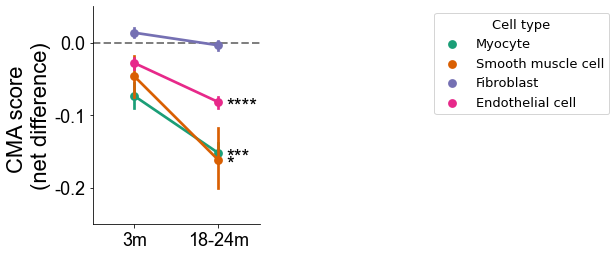

In [24]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='net_score', data=barcode, hue='new_cell', order=["3m", "18-24m"], 
              hue_order=cells, palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.25, 0.05) 
ax.set_yticks([-0.20, -0.10, 0.00])
ax.set_yticklabels([-0.20, -0.10, 0.00], fontdict={'family':'Arial', 'size': 18})

# Legend
celulas = ['Myocyte', 'Smooth muscle cell', 'Fibroblast', 'Endothelial cell']
h, l = ax.get_legend_handles_labels()
ax.legend(h, celulas, bbox_to_anchor=(2, 1), title="Cell type", title_fontsize = "13", fontsize=13) 

# Stats
x1= 1.1   
y1= np.mean(barcode[barcode.new_cell =='myocyte'][barcode.new_age=='18-24m']['net_score']) - (0.014)
y2= np.mean(barcode[barcode.new_cell =='smooth muscle cell'][barcode.new_age=='18-24m']['net_score']) - (0.014)
y3= np.mean(barcode[barcode.new_cell =='endothelial cell'][barcode.new_age=='18-24m']['net_score']) - (0.014)

plt.text(x1, y1, "***", fontsize=20, **hfont)
plt.text(x1, y2, "*", fontsize=20, **hfont)
plt.text(x1, y3, "****", fontsize=20, **hfont)

plt.savefig('../Khwaja_et_al_outputs/Heart/Heart_nscorrect.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [25]:
# Extracting raw values for pointplot graphic
long = []
celula = []
age = []
mean=[]
sem=[]

for x in cells:
    for y in ['3m', '18-24m']:
        n = len(barcode[barcode['new_cell']== x][barcode['new_age']== y].index)
        m = np.mean(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score'])
        s = stats.sem(np.array(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score']))
        
        long.append(n)
        celula.append(x)
        age.append(y)
        mean.append(m)
        sem.append(s)
        
df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "n": long, "Mean":mean, "SEM": sem})
df_raw

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\1532967860.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== x][barcode['new_age']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\1532967860.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\1532967860.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(np.array(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score']))


,Cell_type,Age,n,Mean,SEM
0,myocyte,3m,205,-0.073793,0.019181
1,myocyte,18-24m,345,-0.152210,0.014445
2,smooth muscle cell,3m,65,-0.046719,0.028272
3,smooth muscle cell,18-24m,38,-0.161777,0.041900
4,fibroblast,3m,2118,0.013607,0.005305
5,fibroblast,18-24m,1593,-0.003657,0.006436
6,endothelial cell,3m,1179,-0.028305,0.008026
7,endothelial cell,18-24m,1515,-0.081937,0.007287


In [26]:
df_raw.to_excel('../Khwaja_et_al_outputs/Heart/Raw_data.xlsx', 'Netsc', index=False)

## CMA net score/cell type & sex  (fold over whole tissue)

### Stats

In [27]:
# Calculating n of cells per cell type, sex and age
for i in cells:
    print(i.title() + " length:" + str(len(barcode[barcode["new_cell"]==i].index)))
    print(barcode[barcode["new_cell"]==i].value_counts(["sex", "new_age"]))
    print("\n")

Myocyte length:550
sex     new_age
male    18-24m     280
female  3m         113
male    3m          92
female  18-24m      65
dtype: int64


Smooth Muscle Cell length:103
sex     new_age
female  3m         36
male    18-24m     33
        3m         29
female  18-24m      5
dtype: int64


Fibroblast length:3711
sex     new_age
female  3m         1354
male    18-24m      992
        3m          764
female  18-24m      601
dtype: int64


Endothelial Cell length:2694
sex     new_age
male    18-24m     1244
female  3m          645
male    3m          534
female  18-24m      271
dtype: int64




In [28]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode[barcode['new_cell']==i].reset_index()    
    
    # 2-way Anova
    model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['net_score'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Myocyte 2-way Anova

                      df     sum_sq   mean_sq          F    PR(>F)
C(new_age)           1.0   0.790734  0.790734  10.790341  0.001086
C(sex)               1.0   0.095001  0.095001   1.296382  0.255375
C(new_age):C(sex)    1.0   0.044845  0.044845   0.611957  0.434391
Residual           546.0  40.011800  0.073282        NaN       NaN


Myocyte Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male  0.2673 0.7894       1.0  False
18-24m & female   3m & female -2.2898 0.0232    0.1393  False
18-24m & female     3m & male -0.9278  0.355       1.0  False
  18-24m & male   3m & female -3.4721 0.0006    0.0034   True
  18-24m & male     3m & male  -1.572 0.1168    0.7008  False
    3m & female     3m & male  1.3389 0.1821       1.0  False
------------------------

### Graphs

#### Myocytes

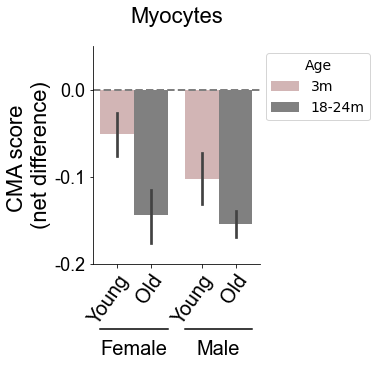

In [32]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell=='myocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.20, 0.05)
ax.set_yticks([-0.20, -0.10, 0.00])
ax.set_yticklabels([-0.20, -0.10, 0.00], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Myocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Heart/Myo_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Smooth muscle cell

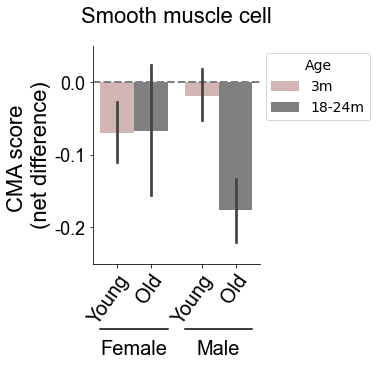

In [35]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell=='smooth muscle cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.25, 0.05)
ax.set_yticks([-0.20, -0.10, 0.0])
ax.set_yticklabels([-0.20, -0.10, 0.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Smooth muscle cell', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Heart/SMc_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Fibroblasts

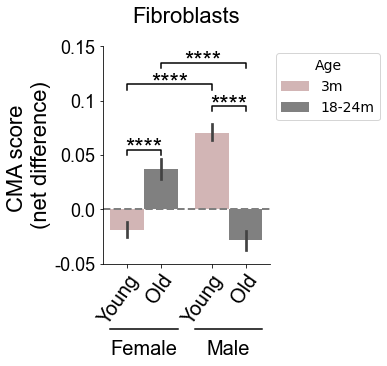

In [54]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell=='fibroblast'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.05, 0.15)
ax.set_yticks([-0.05, 0.0, 0.05, 0.10, 0.15])
ax.set_yticklabels([-0.05, 0.0, 0.05, 0.10, 0.15], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Fibroblasts', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# statistical annotation
x1, x2 = -0.2, 0.2   
y, h, col = 0.05 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.8, 1.2   
y, h, col = 0.09 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -.2, 0.8   
y, h, col = 0.11 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.13 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Heart/Fib_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Endothelial

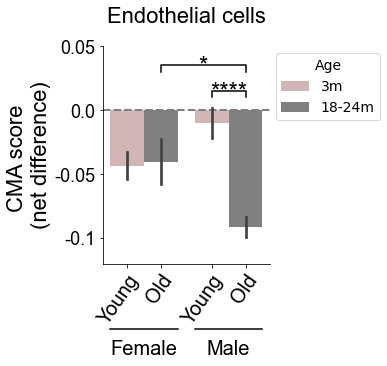

In [66]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell=='endothelial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.12, 0.05)
ax.set_yticks([-0.10, -0.05, 0.0, 0.05])
ax.set_yticklabels([-0.10, -0.05, 0.0, 0.05], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Endothelial cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.01 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.03 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Heart/End_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [67]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Heart/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="Nsbysex", index=False)
    return(df_raw)

In [68]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3730787168.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3730787168.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3730787168.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])


,Cell_type,Age,Sex,n,Mean,SEM
0,myocyte,3m,female,113,-0.050665,0.024567
1,myocyte,3m,male,92,-0.102201,0.030156
2,myocyte,18-24m,female,65,-0.144184,0.032801
3,myocyte,18-24m,male,280,-0.154073,0.016114
4,smooth muscle cell,3m,female,36,-0.069624,0.041975
5,smooth muscle cell,3m,male,29,-0.018284,0.036177
6,smooth muscle cell,18-24m,female,5,-0.066338,0.089200
7,smooth muscle cell,18-24m,male,33,-0.176237,0.046229
8,fibroblast,3m,female,1354,-0.018561,0.006870
9,fibroblast,3m,male,764,0.070615,0.007840


## CMA net score/cell type & sex (fold over each cell type young)

In [69]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['new_cell'])):
    
    µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['new_cell'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\2122786486.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
 10%|████████▎                                                                          | 1/10 [00:00<00:00,  9.97it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\2122786486.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.38it/s]


,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score,new_cell,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,Mus musculus,female,heart,na,18 month-old stage,0.025783,18-24m,-0.001115,B cell,0.133102
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219727,10,...,Mus musculus,female,heart,na,18 month-old stage,0.191401,18-24m,0.164504,B cell,0.298720
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,Mus musculus,female,heart,na,18 month-old stage,0.093941,18-24m,0.067043,B cell,0.201260
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.130371,3,...,Mus musculus,female,heart,na,18 month-old stage,-0.107985,18-24m,-0.134883,fibroblast,-0.148490
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,Mus musculus,female,heart,na,18 month-old stage,-0.015457,18-24m,-0.042355,B cell,0.091862


### Graphs

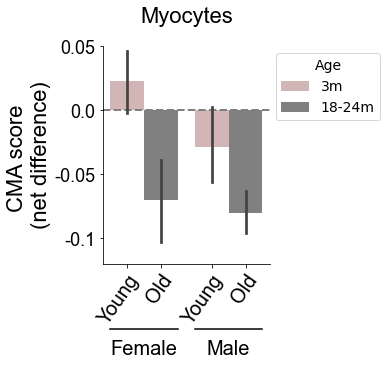

In [71]:
# Figure Myocytes
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='myocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.12, 0.05)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Myocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)


plt.savefig('../Khwaja_et_al_outputs/Heart/Myo_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

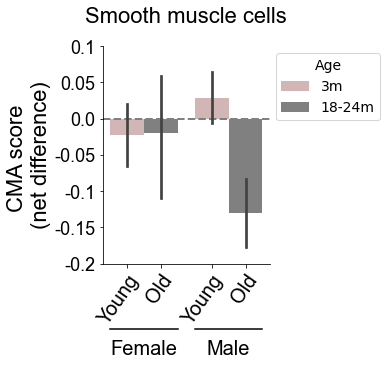

In [74]:
# Figure Smooth muscle cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='smooth muscle cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.2, 0.10)
ax.set_yticks([-0.20, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.20, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Smooth muscle cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Heart/SMc_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

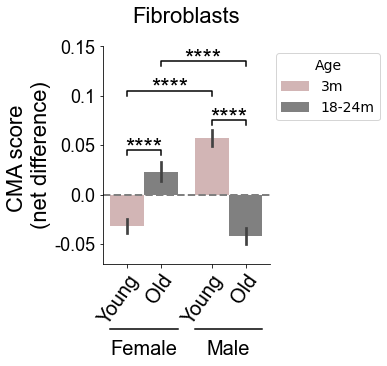

In [82]:
# Figure fibroblasts
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='fibroblast'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.07, 0.15)
ax.set_yticks([-0.05, 0.0, 0.05, 0.10, 0.15])
ax.set_yticklabels([-0.05, 0.0, 0.05, 0.10, 0.15], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Fibroblasts', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# statistical annotation
x1, x2 = -0.2, 0.2   
y, h, col = 0.04 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.8, 1.2   
y, h, col = 0.07 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -.2, 0.8   
y, h, col = 0.10 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.13 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Heart/Fib_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

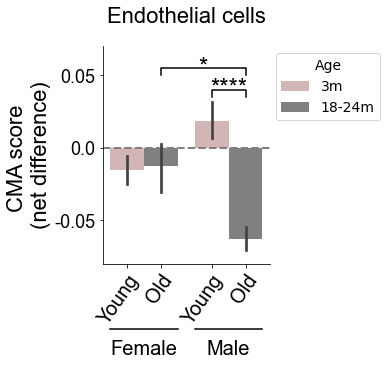

In [94]:
# Figure Endothelial
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='endothelial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.08, 0.07)
ax.set_yticks([-0.05, 0.00, 0.05])
ax.set_yticklabels([-0.05, 0.00, 0.05], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Endothelial cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.035 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.002, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.05 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.003, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Heart/End_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [95]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Heart/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="CellNsbysex", index=False)
    return(df_raw)

In [96]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3182554093.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3182554093.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3182554093.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])


,Cell_type,Age,Sex,n,Mean,SEM
0,myocyte,3m,female,113,0.023128,0.024567
1,myocyte,3m,male,92,-0.028407,0.030156
2,myocyte,18-24m,female,65,-0.070391,0.032801
3,myocyte,18-24m,male,280,-0.080280,0.016114
4,smooth muscle cell,3m,female,36,-0.022906,0.041975
5,smooth muscle cell,3m,male,29,0.028435,0.036177
6,smooth muscle cell,18-24m,female,5,-0.019620,0.089200
7,smooth muscle cell,18-24m,male,33,-0.129518,0.046229
8,fibroblast,3m,female,1354,-0.032167,0.006870
9,fibroblast,3m,male,764,0.057008,0.007840


## CMA network heatmaps by cell type & sex

In [97]:
# Load matrix reordered
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx', 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [102]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Heart/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop+'_heat', index=True)
        
    #Plot heatmap including all conditions
    if cellpop == 'smooth muscle cell':
        matrix_zs = np.delete(matrix_zs,(5), axis=0)
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(15), nogfap, fontsize=16, **hfont)

        plt.ylim(14.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        
        if cellpop == 'endothelial':
            plt.title(cellpop.title()+' cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)
        else:
            plt.title(cellpop.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)
            
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        
        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0.25), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.5, 4.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 9.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.5, 9.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[10, 14.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
        
    else:
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}

        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

        plt.ylim(15.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.title(cellpop.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)

        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    
    plt.savefig('../Khwaja_et_al_outputs/Heart/{}_heat.png'.format(cellpop),bbox_inches='tight', dpi=300)
    
    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == c

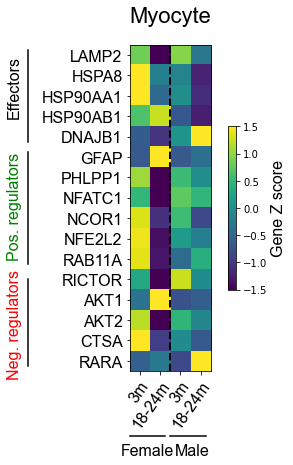

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == c

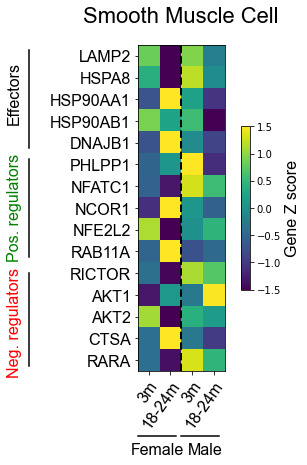

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == c

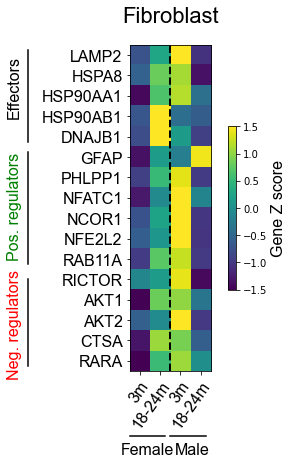

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13124\3776452931.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == c

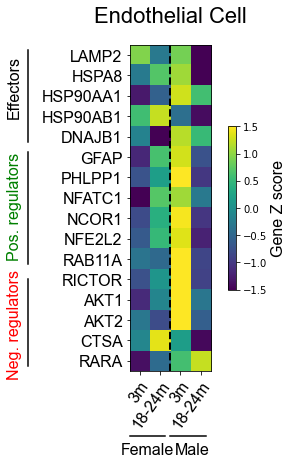

In [103]:
for i in cells:
    sex_heatmaps(cellpop=i)

## Ridge plots for L2 and L1

In [3]:
# Codes for L2 and L1
lys = ['ENSMUSG00000016534', 'ENSMUSG00000031447']

In [4]:
# Selecting only L2 and L1 from adata
adata_lys = adata[:, lys]
barcode_lys = adata.obs.copy()

# Calculating the Z score for L2 & L1
lys_zs = adata_lys.copy().X.todense()

for i in tqdm(np.arange(lys_zs.shape[1])):
    
    µ = np.mean(lys_zs[:, i])
    sd = np.std(lys_zs[:, i])
    
    lys_zs[:, i] = (lys_zs[:, i] - µ)/sd
    
# Converting lys_zs.X to a pandas df
df_lys = pd.DataFrame(lys_zs.tolist())
df_lys.rename(columns={0:"L2", 1:'L1'}, inplace=True)

# Generating barcode df and appending L2 column
barcode_lys = barcode_lys.reset_index()
barcode_lys = pd.concat([barcode_lys, df_lys], axis=1)
barcode_lys = barcode_lys [['index', 'cell', 'cell_type', 'sex', 'age', 'L2', 'L1']]

barcode_lys.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


,index,cell,cell_type,sex,age,L2,L1
0,A10_B001361_B007505_S10.mm10-plus-0-0,A10_B001361,B cell,female,18m,-1.315324,0.293711
1,A11_B001361_B007505_S11.mm10-plus-0-0,A11_B001361,B cell,female,18m,0.665967,0.502130
2,A12_B001361_B007505_S12.mm10-plus-0-0,A12_B001361,B cell,female,18m,-1.315324,-0.165078
3,A13_B001361_B007505_S13.mm10-plus-0-0,A13_B001361,fibroblast of cardiac tissue,female,18m,0.903635,0.335001
4,A14_B001361_B007505_S14.mm10-plus-0-0,A14_B001361,B cell,female,18m,-1.315324,-0.024743


In [5]:
cells = ['myocyte', 'smooth muscle cell', 'fibroblast', 'endothelial cell']

In [6]:
# Generating new ages
for j in barcode_lys.index:    
    if barcode_lys.loc[j, 'age'] == '3m':        
        barcode_lys.loc[j, 'new_age'] = '3m'

    else:                
        barcode_lys.loc[j, 'new_age'] = '18-24m'

# Generating new cell types combining some of them
for j in barcode_lys.index:    
    if barcode_lys.loc[j, 'cell_type'] == 'fibroblast of cardiac tissue':        
        barcode_lys.loc[j, 'new_cell'] = 'fibroblast'

    elif barcode_lys.loc[j, 'cell_type'] == 'endothelial cell of coronary artery':                
        barcode_lys.loc[j, 'new_cell'] = 'endothelial cell'
    
    elif barcode_lys.loc[j, 'cell_type'] == 'regular atrial cardiac myocyte':                
        barcode_lys.loc[j, 'new_cell'] = 'myocyte'
    
    elif barcode_lys.loc[j, 'cell_type'] == 'regular ventricular cardiac myocyte':                
        barcode_lys.loc[j, 'new_cell'] = 'myocyte'
        
    else:
        barcode_lys.loc[j, 'new_cell'] = barcode_lys.loc[j, 'cell_type']
        
barcode_lys.head()

,index,cell,cell_type,sex,age,L2,L1,new_age,new_cell
0,A10_B001361_B007505_S10.mm10-plus-0-0,A10_B001361,B cell,female,18m,-1.315324,0.293711,18-24m,B cell
1,A11_B001361_B007505_S11.mm10-plus-0-0,A11_B001361,B cell,female,18m,0.665967,0.502130,18-24m,B cell
2,A12_B001361_B007505_S12.mm10-plus-0-0,A12_B001361,B cell,female,18m,-1.315324,-0.165078,18-24m,B cell
3,A13_B001361_B007505_S13.mm10-plus-0-0,A13_B001361,fibroblast of cardiac tissue,female,18m,0.903635,0.335001,18-24m,fibroblast
4,A14_B001361_B007505_S14.mm10-plus-0-0,A14_B001361,B cell,female,18m,-1.315324,-0.024743,18-24m,B cell


In [7]:
# Reducing df only to cells of interest
barcode_lys = barcode_lys[barcode_lys['new_cell'].isin(cells)]
print(barcode_lys.new_cell.unique())
barcode_lys.head()

['fibroblast' 'endothelial cell' 'myocyte' 'smooth muscle cell']


,index,cell,cell_type,sex,age,L2,L1,new_age,new_cell
3,A13_B001361_B007505_S13.mm10-plus-0-0,A13_B001361,fibroblast of cardiac tissue,female,18m,0.903635,0.335001,18-24m,fibroblast
7,A17_B001361_B007505_S17.mm10-plus-0-0,A17_B001361,endothelial cell of coronary artery,female,18m,-1.315324,0.566125,18-24m,endothelial cell
17,A5_B001361_B007505_S5.mm10-plus-0-0,A5_B001361,endothelial cell of coronary artery,female,18m,-1.315324,-0.961166,18-24m,endothelial cell
23,B19_B001361_B007505_S43.mm10-plus-0-0,B19_B001361,fibroblast of cardiac tissue,female,18m,0.763279,0.244630,18-24m,fibroblast
25,B6_B001361_B007505_S30.mm10-plus-0-0,B6_B001361,fibroblast of cardiac tissue,female,18m,-1.315324,0.418044,18-24m,fibroblast


### Graphs

#### Lamp2 female

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


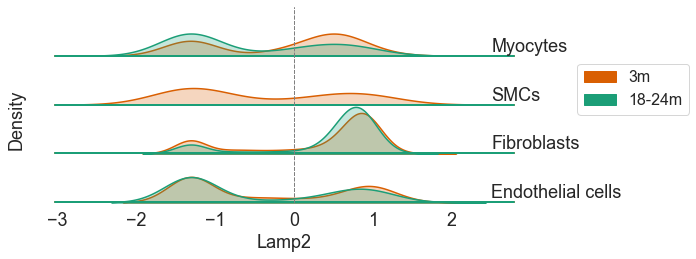

In [9]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.5, y=3.95, s='Myocytes', fontsize=18) 
plt.text(x=2.5, y=2.68, s='SMCs', fontsize=18)
plt.text(x=2.5, y=1.40, s='Fibroblasts'.capitalize(), fontsize=18)
plt.text(x=2.5, y=0.12, s='Endothelial cells', fontsize=18)


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Heart/HeartL2_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp2 male

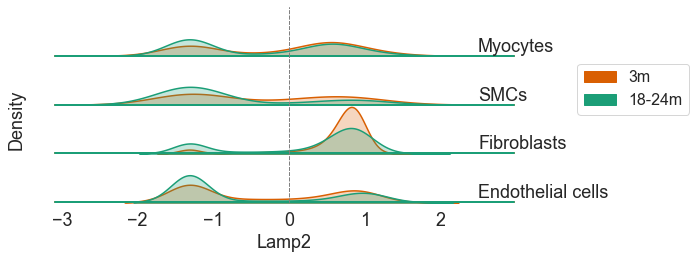

In [10]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.5, y=5.58, s='Myocytes', fontsize=18) 
plt.text(x=2.5, y=3.75, s='SMCs', fontsize=18)
plt.text(x=2.5, y=2.0, s='Fibroblasts'.capitalize(), fontsize=18)
plt.text(x=2.5, y=0.18, s='Endothelial cells', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Heart/HeartL2_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 female

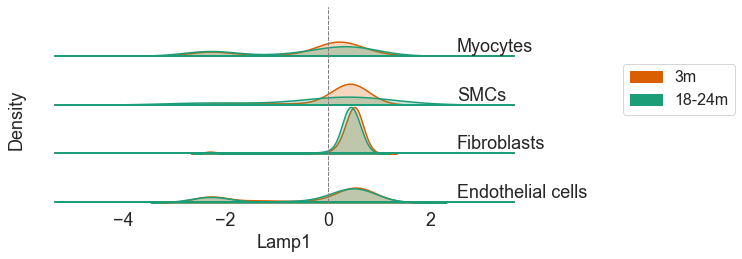

In [11]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.5, y=6.85, s='Myocytes', fontsize=18) 
plt.text(x=2.5, y=4.60, s='SMCs', fontsize=18)
plt.text(x=2.5, y=2.45, s='Fibroblasts'.capitalize(), fontsize=18)
plt.text(x=2.5, y=0.2, s='Endothelial cells', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.5, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Heart/HeartL1_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 male

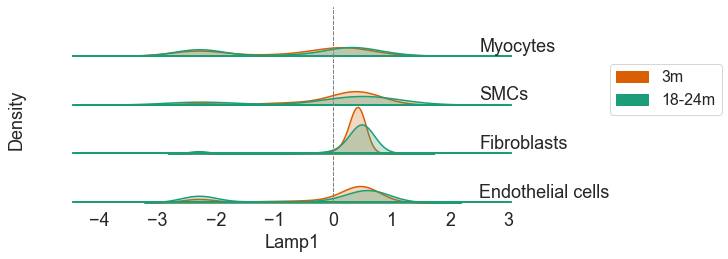

In [12]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.5, y=8.2, s='Myocytes', fontsize=18) 
plt.text(x=2.5, y=5.58, s='SMCs', fontsize=18)
plt.text(x=2.5, y=2.9, s='Fibroblasts'.capitalize(), fontsize=18)
plt.text(x=2.5, y=0.25, s='Endothelial cells', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.5, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Heart/HeartL1_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

## L2 Bar graphs

### Stats

In [93]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode_lys[barcode_lys['new_cell']==i].reset_index(drop=True)    
    
    # 2-way Anova
    model = ols('L2 ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['L2'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Myocyte 2-way Anova

                      df      sum_sq   mean_sq          F    PR(>F)
C(new_age)           1.0    8.872727  8.872727  10.012597  0.001641
C(sex)               1.0    1.478804  1.478804   1.668784  0.196968
C(new_age):C(sex)    1.0    1.004205  1.004205   1.133214  0.287561
Residual           546.0  483.841437  0.886156        NaN       NaN


Myocyte Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male -1.6345 0.1031    0.6184  False
18-24m & female   3m & female -3.0983 0.0023    0.0136   True
18-24m & female     3m & male -2.9907 0.0032    0.0194   True
  18-24m & male   3m & female -2.0209  0.044    0.2638  False
  18-24m & male     3m & male -2.0055 0.0456    0.2738  False
    3m & female     3m & male -0.1495 0.8813       1.0  False
-------------------

### Graphs

In [94]:
sns.reset_defaults()

#### Myocytes

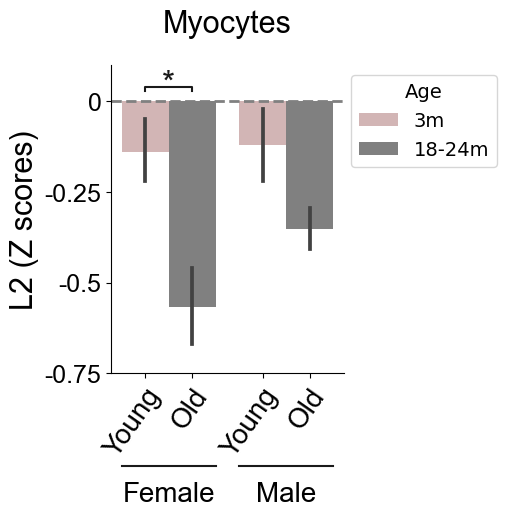

In [106]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell=='myocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.75, 0.10)
ax.set_yticks([-0.75, -0.5, -0.25, 0])
ax.set_yticklabels([-0.75, -0.5, -0.25, 0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Myocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = -0.2, 0.2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h*2.5, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Heart/Myo_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Smooth muscle cells

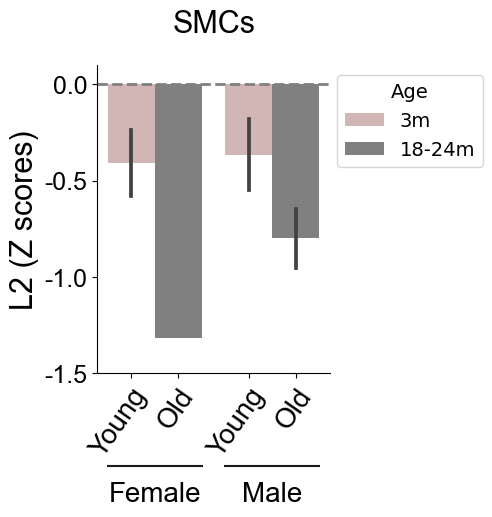

In [130]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell=='smooth muscle cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-1.5, 0.10)
ax.set_yticks([-1.5, -1.0, -0.5, 0.0])
ax.set_yticklabels([-1.5, -1.0, -0.5, 0.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='SMCs', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Heart/SMc_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Fibroblasts

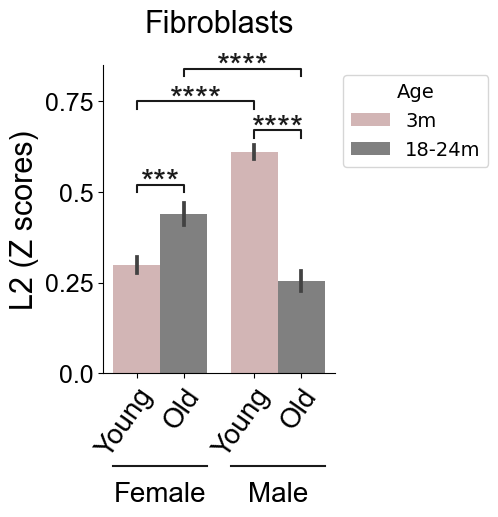

In [143]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell=='fibroblast'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(0, 0.85)
ax.set_yticks([0.0, 0.25, 0.50, 0.75])
ax.set_yticklabels([0.0, 0.25, 0.50, 0.75], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Fibroblasts', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.65 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.02, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -0.2, 0.2   
y, h, col = 0.5, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.02, "***", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -0.2, 0.8   
y, h, col = 0.73 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.02, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.82, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.02, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})


# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Heart/Fib_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Endothelial cells

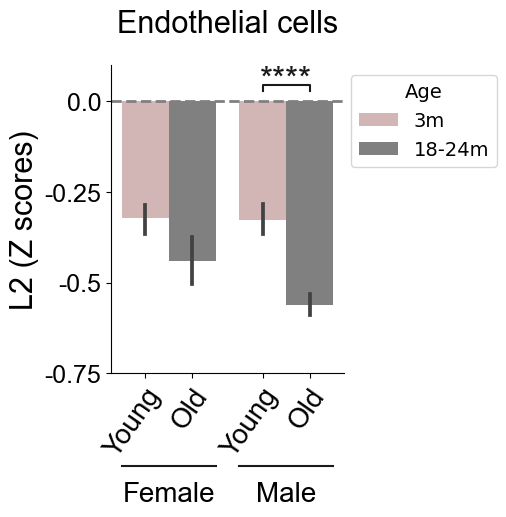

In [152]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell=='endothelial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.75, 0.10)
ax.set_yticks([-0.75, -0.5, -0.25, 0.0])
ax.set_yticklabels([-0.75, -0.5, -0.25, 0.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Endothelial cells', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Heart/End_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [153]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
                m = np.mean(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
                s = stats.sem(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Heart/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="L2bysex", index=False)
    return(df_raw)

In [154]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_11620\2766554852.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_11620\2766554852.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_11620\2766554852.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])


,Cell_type,Age,Sex,n,Mean,SEM
0,myocyte,3m,female,113,-0.138176,0.082951
1,myocyte,3m,male,92,-0.119105,0.097958
2,myocyte,18-24m,female,65,-0.567717,0.112342
3,myocyte,18-24m,male,280,-0.351572,0.058124
4,smooth muscle cell,3m,female,36,-0.409100,0.165689
5,smooth muscle cell,3m,male,29,-0.366557,0.182681
6,smooth muscle cell,18-24m,female,5,-1.315324,0.000000
7,smooth muscle cell,18-24m,male,33,-0.798328,0.157611
8,fibroblast,3m,female,1354,0.299664,0.023311
9,fibroblast,3m,male,764,0.609678,0.019442
